# How to Easily Create Machine Learning Pipelines With DVC
## Create robust, reproducible pipelines with DVC

### What is a machine learning pipeline?

Imagine a machine learning pipeline as an unbreakable tunnel that stretches from one end of a mountain to the other. At the entrance of the tunnel is a massive avalanche of raw data, tumbling and cascading from all directions.

As the data enters the tunnel, it is cleaned, preprocessed, transformed and feature-selected into a form that is usable by machine learning models. Along the way, it passes through a series of checkpoints, where different models and algorithms are trained and tested, selecting only the strongest and most accurate ones to move on.

Finally, at the other end of the tunnel, the data emerges as a fully trained and operational machine learning model, ready to be deployed to the real world.

In a typical ML project, any checkpoint or stage in a pipeline may take dozens or even hundreds of iterations to get right. For this reason, it is imperative to use a reliable tool to track the pipeline building process and make it as straightforward and reproducible as possible.

One of those popular tools in the Python ecosystem is DVC - Data Version Control.

### What you will learn in this tutorial

SHOW A GIF OF `DVC REPRO` IN ACTION ON VSCODE.

### Setup

Start by cloning the `pipelines` branch of the following repository and opening the project with VSCode:

```
$ git clone --branch pipelines https://github.com/BexTuychiev/dvc-tutorial.git dvc-tutorial
$ cd dvc-tutorial
$ code .
```

Install the contents of `requirements.txt` in a virtual environment, preferably `conda`:

```
$ conda create -n dvc-tutorial python==3.9 -y
$ conda activate dvc-tutorial
$ python -r requirements.txt
```

> We will get to the scripts later.

The `pipelines` branch already comes with DVC initialized, so you only have to run `dvc pull` to get the data from the remote storage:

```
$ dvc get REMOTE_LINK # To be added later
```

The `get` command will download the contents of the `data` directory. Afterward, the project's tree structure should look like below:

Afterwards, your project tree should resemble the following structure:

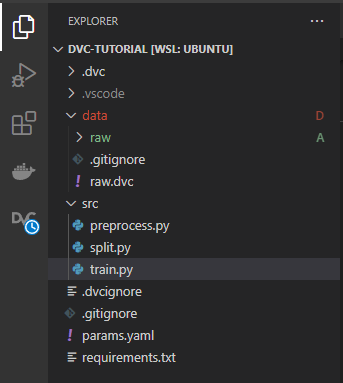

The `raw/train` folder contains images with varying sizes from the [German Traffic Signs Recognition Benchmark dataset](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign). There are 43 classes of traffic signs and over 40k images.

You should also install the [DVC VSCode extension](https://marketplace.visualstudio.com/items?itemName=Iterative.dvc) from the marketplace, if you haven't already done so from the [previous tutorial](THE PREVIOUS TUTORIAL WILL BE LINKED HERE LATER):

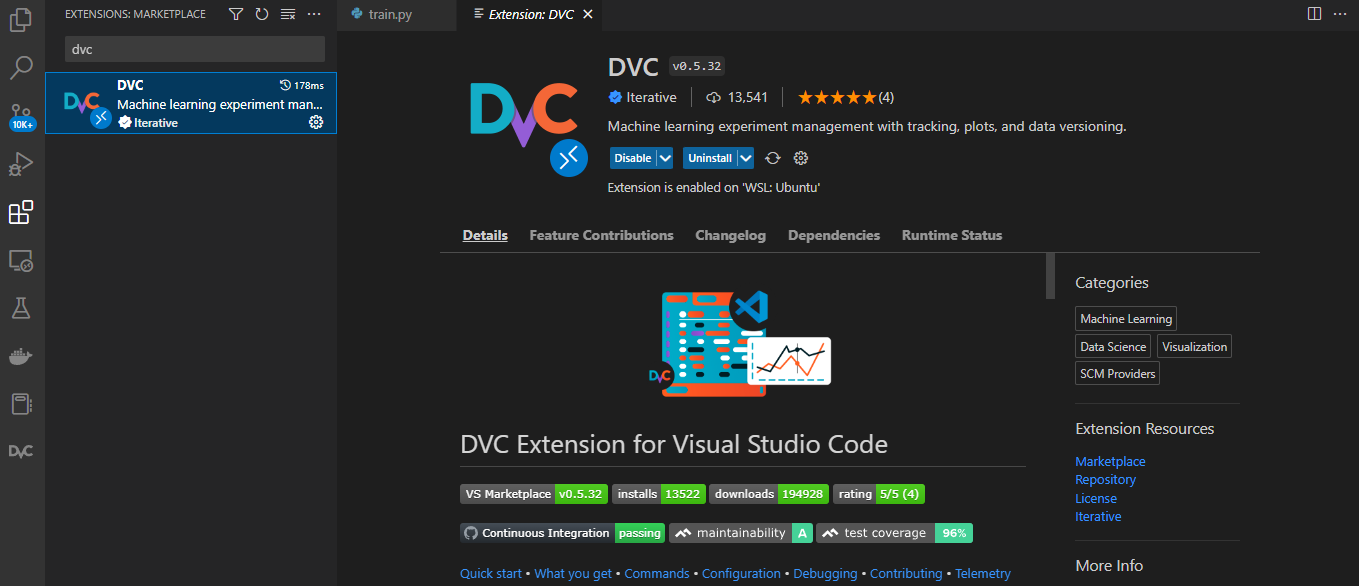

### Keeping track of hyperparameters

If you have multiple pipeline steps, the number of changing hyperparameters can quickly go out of hand. Instead of tweaking them in their own scripts, it is best practice to collect them into a single configuration file. Then, the scripts that need their specific parameters can read them from the configuration file.

DVC-supported hyperparameter tracking file is called a `params.yaml` and the one for our project currently looks like this:

```YAML
split:
  ratio: 0.1

preprocess:
  denoise_weight: 0.03
  image_width: 30
  image_height: 30

train:
  image_width: 30
  image_height: 30
  batch_size: 32
  learning_rate: 0.001
  n_epochs: 10
```

The file contains three parameter groups: `split`, `preprocess` and `train` - one for each stage of our future pipeline. 

The scripts read these parameters using the `params_show` function of `dvc.api`:

```python
from dvc.api import params_show

...

# Load the parameters from params.yaml
params = params_show()["train"]
```

> `params_show` looks for a file named `params.yaml` by default.

Now, `params` is a dictionary containing the `train` stage's parameters as key-value pairs. The script uses this dictionary to pass hyperparameters to functions and classes. Here is an example from the `ImageDataGenerator` class, using the image dimensions and batch size parameters:


```python
train_generator = train_datagen.flow_from_directory(
    data_dir / "raw" / "train",
    target_size=(params["image_width"], params["image_height"]),
    batch_size=params["batch_size"],
    class_mode="categorical",
)
```

We will see the most important benefit of `params.yaml` later.

> As `params.yaml` is lightweight, it is always tracked by Git.

### How to create a pipeline in DVC?

The first stage of our pipeline is the file `split.py`. It splits a proportion of training images inside `data/raw/train` to `data/raw/test`. The proportion is defined as `ratio` inside `params.yaml`.

The important part of `split.py` is not how it splits the training images into another set, but its inputs and outputs. Pipeline stages of different programmers won't ever be the same, the only thing they have in common is their inputs and outputs.

The input to `split.py` is `data/raw/train` directory, which is why the folder is already tracked with DVC. The output is `data/raw/test` directory, which should also be tracked with DVC. Keeping this information about the `ratio` parameter and inputs/outputs, let's build the pipeline stage with the following multi-line CLI command:

```bash
$ dvc stage add -n split \
                -d data/raw/train -d src/split.py \
                -o data/raw/test \
                -p split.ratio \
                python src/split.py
```

The command generates the following `dvc.yaml` file:

```yaml
stages:
  split:
    cmd: python src/split.py
    deps:
    - data/raw/train
    - src/split.py
    params:
    - split.ratio
    outs:
    - data/raw/test

```

The `dvc.yaml` file defines how our data flows through our pipeline, including the scripts it passes through, the files, folders and hyperparameters those scripts use and produce.

So, let's map the CLI command to the fields in `dvc.yaml`. 

1) The `stage add -n split` creates a stage named `split` under the `stages` field of `dvc.yaml`. 
2) The `-d` tags specify the dependency required by the stage to run without errors. These are always the script to run the stage (`split.py`) and any data or model files `data/raw/train`.

> Note that the input to the first pipeline stage should always be tracked with DVC.

3) The `-o` tag specifies the output produced by the pipeline, which is `data/raw/test`. The tag also tells DVC to track it as soon as it is produced by the pipeline stage.
4) The `-p` tag tells DVC which parameters or a parameter group to read from the `params.yaml`. If only `split` was passed to `-p`, all parameters under the stage would be loaded.
5) The final line is the actual command to run the script, which is `python src/split.py`

The same command could have been written in this more explicit syntax:

```bash
$ dvc stage add --name split \
                --deps data/raw/train
                --deps src/split.py
                --outs data/raw/test
                -p split.ratio \
                python src/train.py
```

To run the pipeline, call `dvc repro`:

![](images/dvc_repro1.gif)

That's it! We've created a basic pipeline. 

On top of everything, the pipeline is smart - it automatically detects if there are changes to the inputs/outputs of pipeline stages. If there aren't it skips the stage to save time and compute resources:

![](images/dvc_repro2.gif)

For example, if there are five pipeline stages and you only changed stage three, DVC only runs stage three onwards when `dvc repro` called.

> How? Using a new file called `dvc.lock` which is generated (or updated) whenever `dvc repro` is called. You can learn more about the file from [this page](https://dvc.org/doc/user-guide/project-structure/dvcyaml-files#dvclock-file) of DVC docs.

### How to track metrics and plots in DVC?

The `preprocess` stage is added to the pipeline in a similar way:

```
$ dvc stage add -n preprocess \
                -d data/raw -d src/preprocess.py \
                -o data/prepared \
                -p preprocess \
                python src/preprocess.py
```

The script contains two functions to resize images and apply denoising using Total Variation filtering. Again, the contents of the script are not as important as the inputs/outputs it uses. 

The final `train` stage is tricky. Its input can be either `data/raw/` or `data/test` folders (depending on whether we want to use denoised images or the original ones). Its output is the best model found using the `ModelCheckpoint` of Keras:

```python
# Create a path to save the model
    model_path = BASE_DIR / "models"
    model_path.mkdir(parents=True, exist_ok=True)

callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            model_path / "model.keras", monitor="val_accuracy", save_best_only=True
        ),
        ...
    ]
```

So, one of its outputs is the `models` directory. Another output directory is generated by the `dvclive.keras.DVCLiveCallback`:

```python
from dvclive.keras import DVCLiveCallback


callbacks = [
        ...
        DVCLiveCallback(dir="evaluation"),
    ]
```

`dvclive` is a helper library that can report live metrics on the training process of many deep learning frameworks. 

> Please read the previous part of this tutorial to learn more about how to use `dvclive`.

Before we contain all these info into a pipeline stage, let's plain-run the `train.py` script:

```
$ python src/train.py
```

... And explore the `evaluation` directory. 

```
evaluation/
├── metrics.json
├── plots
│   └── metrics
│       ├── eval
│       │   ├── accuracy.tsv
│       │   ├── loss.tsv
│       │   ├── precision.tsv
│       │   └── recall.tsv
│       └── train
│           ├── accuracy.tsv
│           ├── loss.tsv
│           ├── precision.tsv
│           └── recall.tsv
└── report.html
```

The first file we will look at is `metrics.json`:

```json
$ cat evaluation/metrics.json

{
    "train": {
        "loss": 0.16159354150295258,
        "accuracy": 0.9504377841949463,
        "precision": 0.9632779955863953,
        "recall": 0.9403213262557983
    },
    "eval": {
        "loss": 0.04795863479375839,
        "accuracy": 0.9829081892967224,
        "precision": 0.9849027395248413,
        "recall": 0.9818877577781677
    },
    ...
}
```

The file contains the performance of the best model from the training loop in a special format that is recognized by DVC. This `metrics.json` will enable us to compare different machine learning experiments later.

Another directory is `plots`:

```
evaluation/
├── metrics.json
├── plots
│   └── metrics
│       ├── eval
│       │   ├── accuracy.tsv
│       │   ├── loss.tsv
│       │   ├── precision.tsv
│       │   └── recall.tsv
│       └── train
│           ├── accuracy.tsv
│           ├── loss.tsv
│           ├── precision.tsv
│           └── recall.tsv
└── ...
```

It contains the training and validation performance of the model at each epoch (step):

```TSV
$ cat accuracy.tsv
step    train/accuracy
0       0.7612287402153015
1       0.9504377841949463
...
````

That is the best feature of DVCLive - it automatically logs all this information with a single line of code.

> Remove the `dvclive` and `models` directories before adding a pipeline stage with `rm -rf dvclive models`.

Now that we understand the output of DVCLive, let's capture them all into a pipeline stage:

```
$ dvc stage add -n train \
                -d data -d src/train.py \
                -o models \
                -O evaluation/report.html \
                -M evaluation/metrics.json \
                --plots evaluation/plots \
                python src/train.py
```

We introduced three new tags:

1) `-O` also captures an output but doesn't let DVC track it. The output here is `report.html`, which is a file that combines all the plots of `DVCLiveCallback`.
2) `-M` captures a specially formatted metrics file, like our `metrics.json` and DOES NOT put it into DVC cache.
3) `--plots` captures a plots file or actual plots as PNG or JPEG files. Here, it is capturing those specially formatted TSV (tab-separated values) plots files.

Our pipeline is ready! Now, instead of running it with `dvc repro`, we run it with `dvc exp run` - as a DVC experiment.

> Let's make a snapshot of all the changes before moving on:

```
$ git add --all
$ git commit -m "Finalize the pipeline"
```

### Tracking pipeline runs as experiments

In the last tutorial (the link will be added later), we got to produce an experiment table like below:

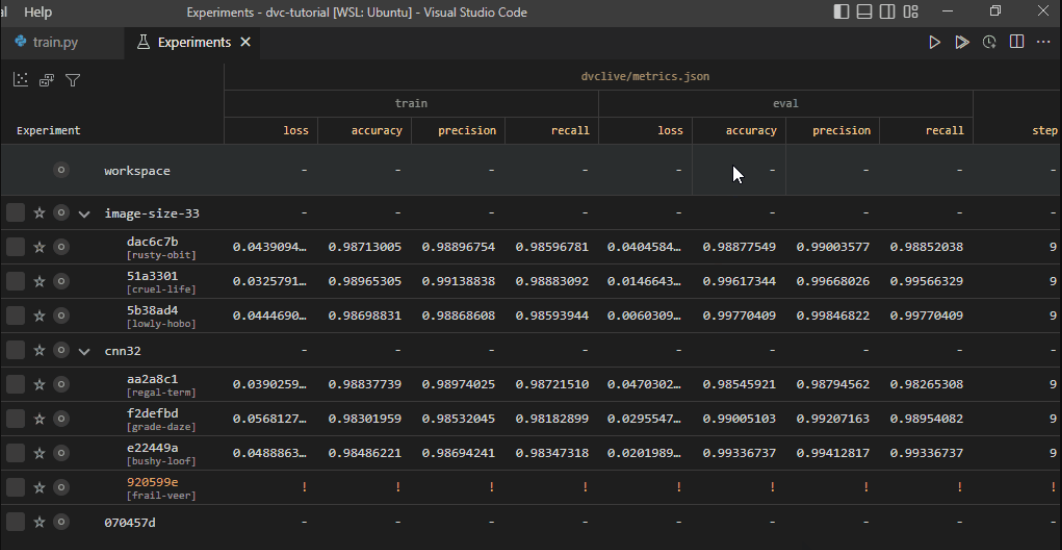

We learned how to group experiments by linking them to specific tags like `cnn32` or `image-size-33` you see above. We will do the same here. 

Create a tag named `denoised_images` as we will be using the preprocessed images compared to the original images used last time.

> It is OK if you don't have the table above. It won't affect the coming steps.

```
$ git tag "denoised_images"
```

Now, run your first experiment by calling `dvc exp run`. The command will automatically detect the `dvc.yaml` and will run your entire pipeline as an experiment:

![](images/pipe_experiment.gif)

As you can see at the end of the GIF, the row contains every single parameter of pipeline stages and 8 metrics for both training and validation sets. 

Let's run a few more experiments via different ways. For example, using the IDE:

![](images/ide_experiment.gif)

Right-click on the `workspace` row and select "Modify and Run" will bring up a list of parameters to modify. We chose learning rate and n_epochs and provided new values to it. The process will automatically update the `params.yaml` file and run the experiment.

If you like the terminal, you could do the following:

```
$ dvc exp run -S train.image_width=33 -S train.image_height=33 train.learning_rate=0.003
```

![](images/terminal_experiment.gif)

Or you could queue multiple experiments with `--queue` tag and run them in succession under the hood:

```
$ dvc exp run -S train.batch_size=64 -S train.n_epochs=10 --queue
$ dvc exp run -S train.batch_size=64 -S train.n_epochs=10 -S train.learning_rate=0.01 --queue
$ dvc exp run -S train.n_epochs=10 -S train.learning_rate=0.1 --queue
$ dvc queue start
```

You can learn more about running and managing experiments and queues from [this page](https://dvc.org/doc/user-guide/experiment-management) of the DVC docks.

### Conclusion

Massive congratulations to taking important steps to clean, organized, reproducible machine learning projects! Here is an outline of the steps you should take to set up an experiment management system with DVC when starting a new project:

1. Track and store large files with `dvc add` and `dvc push`.
2. Create the scripts for stages of a pipeline. A typical pipeline consists of preprocessing, training and evaluation stages.
3. Add each stage with `dvc stage add` commands, specifying dependencies with `-d`, outputs to track with DVC with `-o`, metrics with `-M`, plots with `--plots` and so on.
4. Capture metrics, plots automatically using `dvclive` library and using framework-specific callbacks.
5. Create a `params.yaml` file that lists hyperparameters of each pipeline stage. Use the `dvc.api.params_show` function inside your stage scripts to read the parameters as key-value pairs.
6. Run your entire pipeline as an experiment with `dvc exp run` or queue multiple experiments with `dvc exp run --queue`.
7. Manage and compare experiments using the DVC extension's view pane inside VSCode. 
8. Persist only chosen experiments to Git history with `dvc exp apply exp_ID` and `git add/git commit`. 
9. Iterate.

Thank you very much for reading!